# Lab 6 - Confidence Intervals
#### Aidan Berres
#### Physics 434
#### 11/22/20

In [64]:
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [3]:
uv = UVData()
uv.read('hera1.hd5',file_type='uvh5')

In [147]:
uv.get_data(140,23).shape

(20, 1536)

In [143]:
p=uv.get_antpairs()
freqs = uv.freq_array[0]*1e-6

In [144]:
freqs.size

1536

In [38]:
bg1=np.array([])
i=0
j=0
while j<1000000:
    d=abs(uv.get_data(p[i]).flatten())
    bg1=np.append(bg1,d)
    j=len(bg1)
    i=i+1
print(i)

33


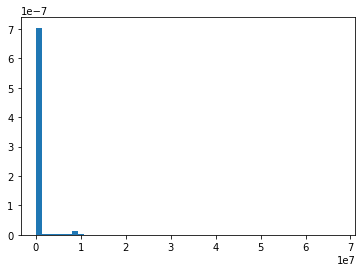

In [35]:
plt.hist(bg1,bins=50,density=True);

In [40]:
maria=np.array([])
for i in range(100):
    d=abs(uv.get_data(p[i]).flatten())
    maria=np.append(maria,d)

In [42]:
bg2=np.random.choice(maria,size=1000000)

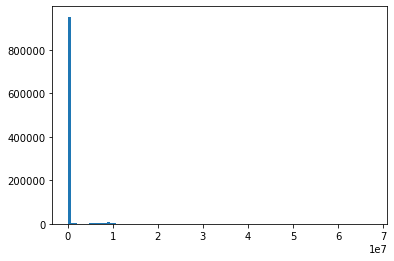

In [44]:
plt.hist(bg2,bins=100);

In [46]:
ma=np.array([])
for i in range(len(p)):
    ria=abs(uv.get_data(p[i]))
    ma=np.append(ma,ria[0])

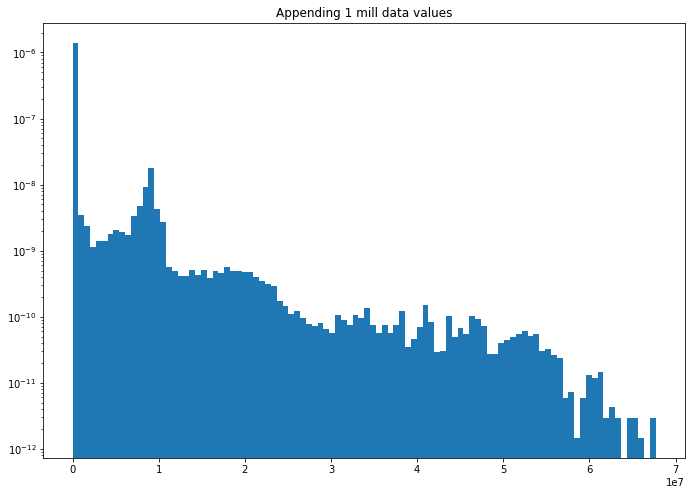

In [63]:
plt.subplots(figsize=(11.5,8))
plt.title('Appending 1 mill data values')
plt.yscale('log')
plt.hist(bg1,bins=100,density=True);

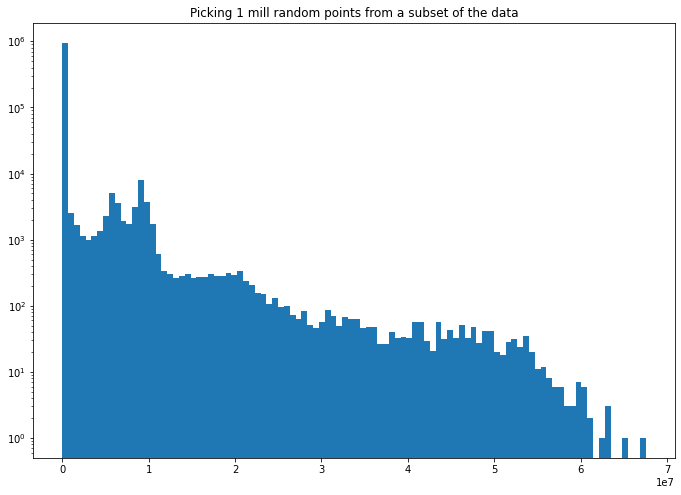

In [59]:
plt.subplots(figsize=(11.5,8))
plt.title('Picking 1 mill random points from a subset of the data')
plt.yscale('log')
plt.hist(bg2,bins=100);

In [95]:
m1=ma.mean()
s1=ma.std()

In [224]:
ma=np.array([])
#mask=np.ma.masked_where(freqs<60,freqs)
for i in range(len(p)):
    ria=abs(uv.get_data(p[i]))
    ria=ria[0]
    #ria=np.ma.masked_where(freqs<60,ria)
    ma=np.append(ma,ria)

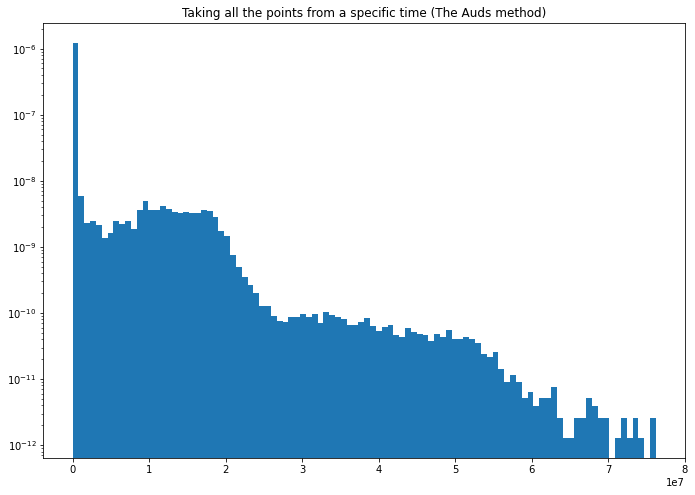

In [225]:
#Aud's Method
fig,ax=plt.subplots(figsize=(11.5,8))
plt.title('Taking all the points from a specific time (The Auds method)')
plt.yscale('log')
plt.hist(ma,bins=100,density=True);

In [192]:
bt = []
for i in range(666):
    d = abs(uv.get_data(p[i]))
    bt.append(d[0])

array([2779568., 2803722., 2869481., ..., 4451972., 4430673., 4408317.])

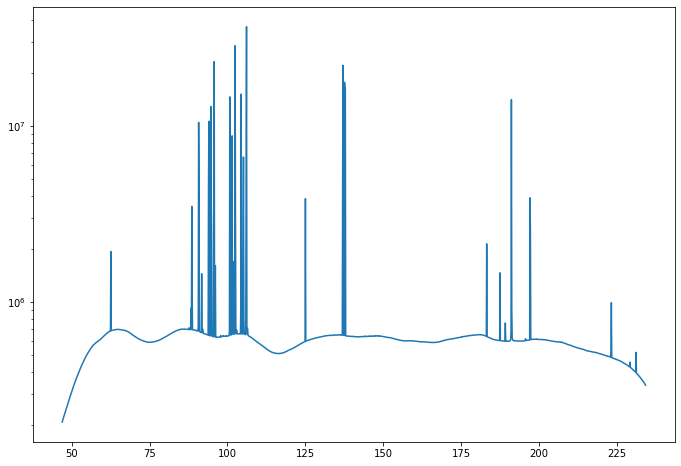

In [199]:
fig,ax=plt.subplots(figsize=(11.5,8))
bt = np.array(bt)
mc=bt.mean(axis=0)
plt.yscale('log')
plt.plot(freqs,mc);

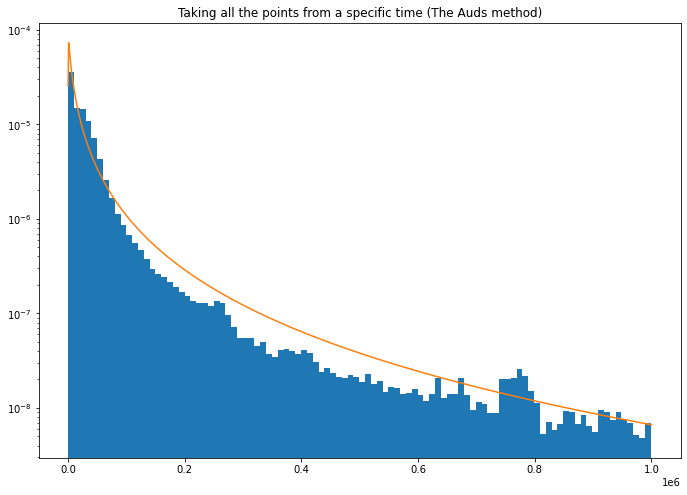

In [335]:
#Aud's Method
fig,ax=plt.subplots(figsize=(11.5,8))
plt.title('Taking all the points from a specific time (The Auds method)')
plt.yscale('log')
max_maria=1e6
masha= np.linspace(0,max_maria,1000)
maria_sub= maria[abs(maria)<max_maria]
sig,one,two=stats.lognorm.fit(maria_sub)
plt.hist(maria_sub,bins=100,density=True);
plt.plot(masha,stats.lognorm.pdf(masha,s=sig,loc=one,scale=two));

In [181]:
stats.lognorm.ppf(siggy5,s=sig,loc=one,scale=two)

42970588.40081523

In [176]:
7.8e5

780000.0

In [66]:
siggy5=stats.norm.cdf(5)


In [73]:
np.ceil(ax.get_xlim()[0])

-3811354.0

In [108]:
sig

2.296151144067993

In [126]:
np.mean(ma)*4

136112.5990403085

In [122]:
masha= np.linspace(0,785654,1000)

## Problem 2

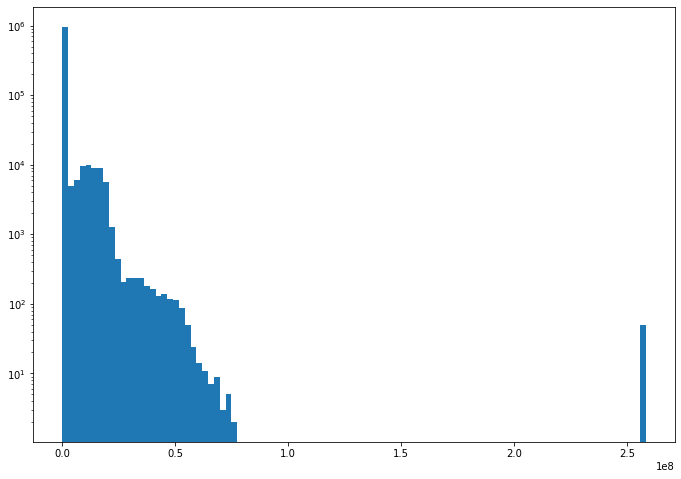

In [284]:
fig,ax=plt.subplots(figsize=(11.5,8))
sha = stats.lognorm.rvs(s=sig,loc=42970588.40081523*(30/5),scale=two,size=50) # possibly wrong
#alt method
#sha=[]
#for i in range(50):
#    sha.append(42970588.40081523*(30/5))
ma_c = np.append(ma,sha)
plt.yscale('log')
plt.hist(ma_c,bins=100);

In [298]:
sha = (np.random.rand(maria.size) < 0.25)*42970588.40081523*(6/5)

In [290]:
sha

array([100,   0,   0, ..., 100,   0,   0])

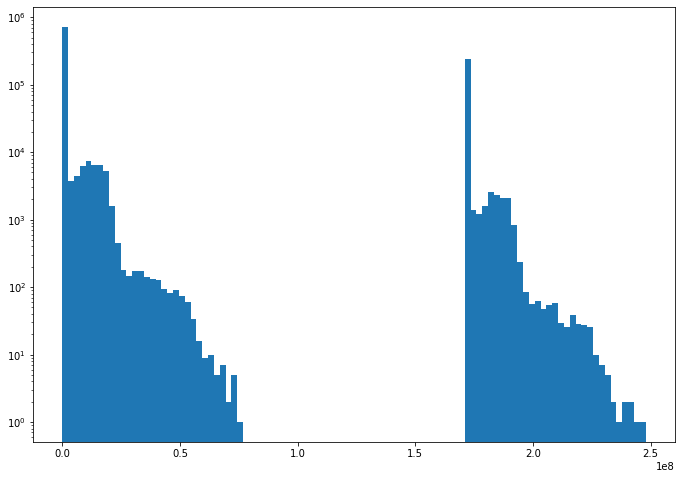

In [340]:
sha = (np.random.rand(ma.size) < 0.25)*42970588.40081523*(20/5)
fig,ax=plt.subplots(figsize=(11.5,8))
plt.yscale('log')
jinji=ma+sha
plt.hist(jinji,bins=100);

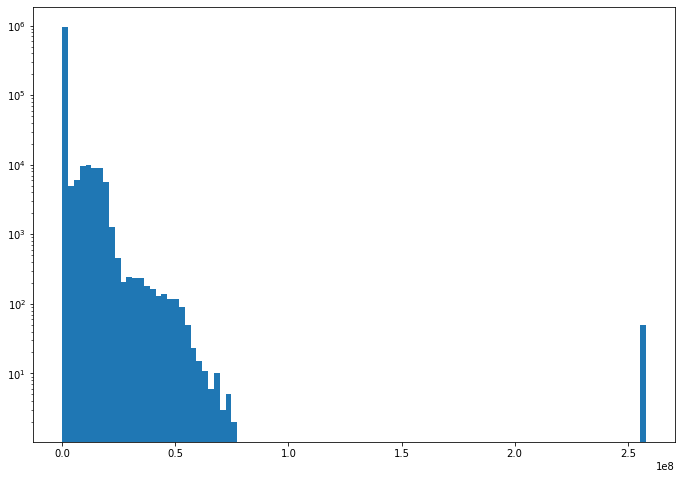

In [228]:
fig,ax=plt.subplots(figsize=(11.5,8))
#sha = stats.norm.rvs(loc=42970588.40081523*(30/5)) # possibly wrong
# alt method (multiple times)
sha=[]
for i in range(50):
    sha.append(42970588.40081523*(30/5))
ma_c = np.append(ma,sha)
plt.yscale('log')
plt.hist(ma_c,bins=100);

### Write something *here*
yes i should

## Problem 3

In [354]:
sha = (np.random.rand(ma.size) < 0.25)*42970588.40081523*(1/5)
jinji=ma+sha

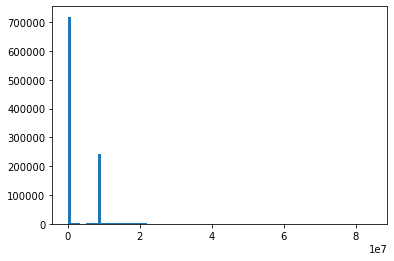

In [355]:
plt.hist(jinji,bins=100);

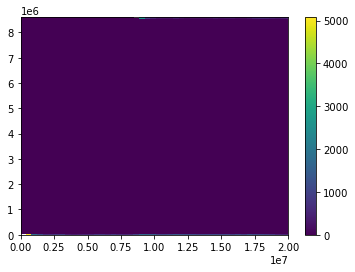

In [376]:
hist=np.histogram2d(jinji,sha,bins=200)
plt.hist2d(jinji,sha,bins=200,cmin=0,cmax=10000);
#plt.ylim(0,200)
plt.xlim(0,2e7)
plt.colorbar();

In [341]:
data =jinji
signal = sha1
signaledges = np.linspace(0,30,40)
dataedges = np.linspace(-7,27,68)

Psd, temp, temp2= np.histogram2d(data,signal, bins=[dataedges,signaledges], density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
plt.pcolormesh(datacenters,signalcenters,Psd.T)
plt.ylabel('True signal, $P(s|d)$', fontsize = 24)
plt.xlabel('Observed data, $P(d|s)$', fontsize = 24);

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

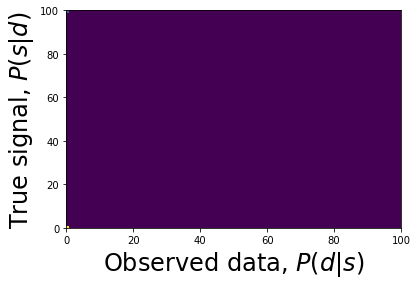

In [345]:
data=jinji
signal = sha
signaledges = np.linspace(0,20,40)
dataedges = np.linspace(-7,27,68)

Psd, temp, temp2= np.histogram2d(data,signal,bins=100 ,density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
plt.pcolormesh(Psd.T)
plt.ylabel('True signal, $P(s|d)$', fontsize = 24)
#plt.xlim(0,20)
plt.xlabel('Observed data, $P(d|s)$', fontsize = 24);

In [346]:
Psd

array([[9.22227583e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.06482015e-05],
       [4.45379321e-07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.47733077e-07],
       [1.72611738e-07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.80929549e-08],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.28240519e-10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.28240519e-10, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.28240519e-10]])

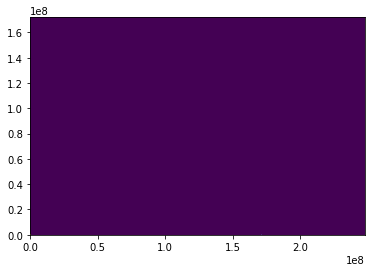

In [307]:
plt.hist2d(jinji,sha,bins=200);
#plt.ylim(0,1e6)

In [231]:
jin1

array([17253038.8386865 , 17253401.13069627, 17254964.16742424, ...,
       17204950.91600535, 17209757.96944136, 17192951.31059913])

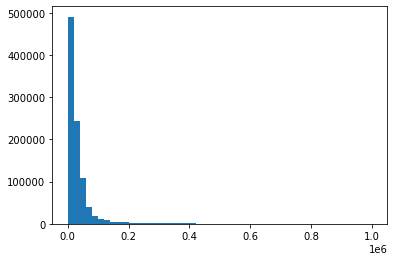

In [277]:
plt.hist(jinji,bins=50);

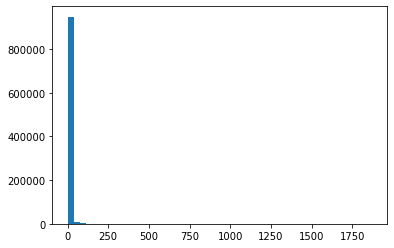

In [280]:
plt.hist(sha1,bins=50);

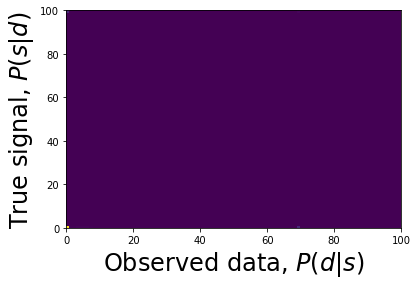

In [306]:
sha = (np.random.rand(ma.size) < 0.1)*42970588.40081523*(20/5)
#sha_a = (np.random.rand(ma.size) < 0.1)*42970588.40081523*(np.linspace(0,30,200)/5)
data=jinji
signal = sha
signaledges = np.linspace(0,20,40)
dataedges = np.linspace(-7,27,68)

Psd, temp, temp2= np.histogram2d(data,signal,bins=100 ,density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
plt.pcolormesh(Psd.T)
plt.ylabel('True signal, $P(s|d)$', fontsize = 24)
plt.xlabel('Observed data, $P(d|s)$', fontsize = 24);

#DO NOT RUN THIS WILL MAX OUT RAM
#hist=np.histogram2d(sha_arr,bins=200)
plt.pcolormesh(sha_arr)